In [2]:
import pandas as pd
from datetime import datetime
from datetime import timedelta
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

import os
import sys
import inspect

# code to manage where are lunch the file
if str(os.getcwd()).split("/")[-1] == "notebooks":
    sys.path.insert(1, os.path.realpath(os.path.pardir))
    path_b = "../"
else:
    path_b ='./'
import config as c

In [3]:
windows = c.windows
number_crypto = c.number_cyptos
market_cap = c.market_cap

df_name_index = pd.read_csv(f"{path_b}data/processed/first_{number_crypto}_crypto_list.csv", index_col=0)
df = pd.read_csv(f"{path_b}data/processed/market_cap_crypto.csv", index_col=0)

df_close_price = pd.read_csv(f'{path_b}data/processed/close_price_crypto.csv', index_col=0)
df_close_price['date'] = pd.to_datetime(df_close_price.index)
df_close_price['date'] = df_close_price['date'].dt.date
df_close_price.index = df_close_price['date']
del df_close_price['date']

# processing part Data

In [4]:
## use market cap file

df_market_cap = pd.read_csv(f'{path_b}data/processed/crypto_date_marketcap_1mio_sorted.csv', index_col=0)


df_market_cap_first_20 = df_market_cap.iloc[:number_crypto]

#select last date
first_date = df_market_cap_first_20['first_date_marketcap_1mio'].tail(1).values

first_date_final = pd.to_datetime(first_date[0])

# TODO: change way to do it in the index
df_final_data = df_close_price.drop(df_close_price[df_close_price.index < first_date_final].index)
df_final_data = df_final_data[df_market_cap_first_20['crypto_name']]
df_final_data_return = np.log(df_final_data/df_final_data.shift(1)).dropna()
df_final_data_return


/Users/guillaume/MyProjects/HECProject/qarm_2/project/venv/lib/python3.8/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


,bitcoin,litecoin,ripple,nxt,dogecoin,digibyte,dash,monero,bitshares,stellar,verge,nem,ethereum,siacoin,decred,lisk,digixdao,steem,bytecoin-bcn,augur
date,,,,,,,,,,,,,,,,,,,,
2016-05-15,0.004154,0.013130,-0.002095,-0.018609,-0.002228,-0.010552,0.007673,-0.018130,-0.009485,-0.010781,-0.002858,0.024035,-0.027459,0.084403,0.008854,0.005746,-0.174393,-0.004085,0.032507,-inf
2016-08-22,0.009323,0.011603,-0.008555,-0.114880,-0.011056,-0.067621,0.057644,0.452871,0.006151,0.005967,-0.262964,-0.017693,-0.005229,-0.027023,-0.016093,-0.074562,0.006834,-0.063908,0.013577,inf
2016-08-23,-0.005705,0.072111,0.003205,-0.064074,-0.007486,0.006593,-0.057249,0.167228,-0.069761,-0.021853,-0.004145,-0.111508,-0.008153,-0.052826,-0.033649,-0.055564,0.018404,-0.140625,-0.006159,0.047461
2016-08-24,-0.005557,-0.019441,0.005319,-0.044452,0.015973,-0.004972,-0.010692,-0.063691,-0.015644,0.005607,-0.013491,0.036327,0.000489,-0.028556,0.026042,-0.038260,0.020776,-0.024216,-0.005825,0.044504
2016-08-25,-0.004182,-0.013838,0.004552,0.136199,-0.006694,0.029472,-0.075378,-0.064704,0.073030,-0.007937,0.004162,0.017597,0.028707,-0.028507,-0.007190,-0.017857,-0.026936,-0.146573,-0.116266,0.001544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-13,0.023979,0.027571,0.023795,-0.013324,0.027594,0.012086,0.014914,-0.008021,0.053286,0.098601,0.018269,0.016899,0.032016,0.044714,-0.011579,0.033829,0.034404,0.077145,-0.002416,0.041868
2021-10-14,-0.001387,0.013921,0.003471,0.029328,-0.001288,0.004284,0.014591,-0.031430,0.050443,0.004513,0.035400,0.009984,0.048659,0.006857,-0.010928,0.032469,0.049268,0.024648,0.000398,0.012307
2021-10-15,0.071887,0.047149,0.007246,0.025193,0.006476,0.023565,0.038597,0.026908,0.020807,-0.021601,0.030662,-0.028598,0.020036,-0.022478,-0.020213,0.026536,0.022625,-0.080672,0.065226,-0.050997


In [5]:
#Long Asset with Low Vol
df_vol = df_final_data_return.rolling(windows).std().dropna()
returns_vol_quantile = df_final_data_return.T.apply(lambda x: pd.qcut(x, 5, labels=False, duplicates="drop"), axis=0).T

In [6]:
for i in returns_vol_quantile.columns:
    returns_vol_quantile.loc[returns_vol_quantile[i] == 0, i] = 0.5 # First quantile for vol
    returns_vol_quantile.loc[returns_vol_quantile[i] == 1, i] = 0
    returns_vol_quantile.loc[returns_vol_quantile[i] == 2, i] = 0
    returns_vol_quantile.loc[returns_vol_quantile[i] == 3, i] = 0
    returns_vol_quantile.loc[returns_vol_quantile[i] == 4, i] = -0.5

## Low Vol part ##
returns_low_vol_quantile = returns_vol_quantile.replace(0.5,1)
returns_low_vol_quantile = returns_low_vol_quantile.replace(-0.5,0)
returns_low_vol_quantile['sum'] = returns_low_vol_quantile.sum(axis=1)

#better to do things => here Low Vol portfolio
# Do the same things about High vol
for i in tqdm(returns_low_vol_quantile.index):
    number = returns_low_vol_quantile['sum'].loc[i]
    for column in returns_low_vol_quantile.columns:
        returns_low_vol_quantile[column].loc[i] = returns_low_vol_quantile[column].loc[i] / number

del returns_low_vol_quantile['sum']

## High Vol part ##

returns_high_vol_quantile = returns_vol_quantile.replace(-0.5,1)
returns_high_vol_quantile = returns_high_vol_quantile.replace(0.5,0)
returns_high_vol_quantile['sum'] = returns_high_vol_quantile.sum(axis=1)

#better to do things => here Low Vol portfolio
# Do the same things about High vol
for i in tqdm(returns_high_vol_quantile.index):
    number = returns_high_vol_quantile['sum'].loc[i]
    for column in returns_high_vol_quantile.columns:
        returns_high_vol_quantile[column].loc[i] = returns_high_vol_quantile[column].loc[i] / number

del returns_high_vol_quantile['sum']

100%|██████████| 1884/1884 [00:21<00:00, 87.60it/s]


In [7]:
# TODO: debug return
diff = df_final_data_return.shape[0] - returns_high_vol_quantile.shape[0]
df_return_vol = df_final_data_return.iloc[diff+2:,]

low_vol_return = np.multiply(df_return_vol, returns_low_vol_quantile.iloc[diff+2:,])
low_vol_perf = np.sum(low_vol_return,1)

high_vol_return = np.multiply(df_return_vol, returns_high_vol_quantile.iloc[diff+2:,])
high_vol_perf = np.sum(high_vol_return,1)



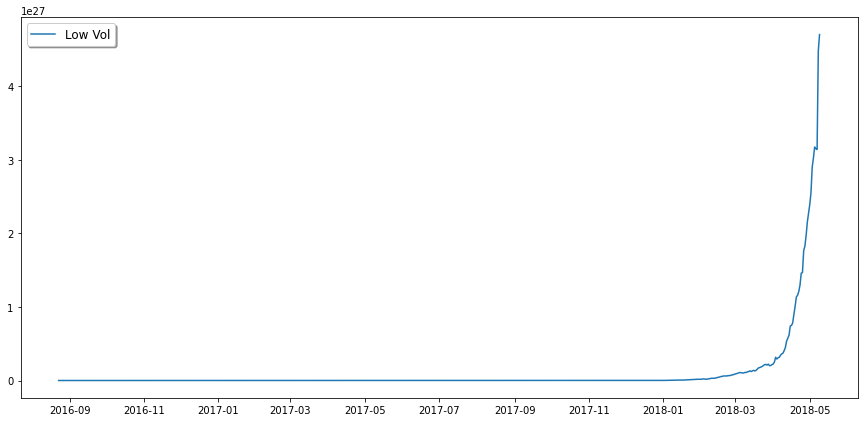

In [11]:
plt.figure(figsize=(15,7))
#plt.plot((low_vol_perf+1).cumprod()*100)
plt.plot((high_vol_perf+1).cumprod()*100)
plt.legend(['Low Vol'],loc='upper left',fontsize='large',fancybox=True, shadow=True)
plt.show()

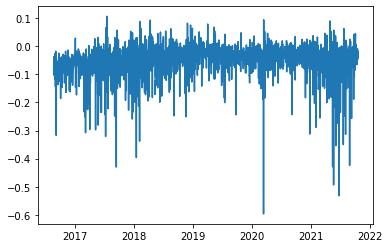

In [9]:
plt.plot(low_vol_perf)

In [10]:
low_vol_perf

date
2016-08-23   -0.096492
2016-08-24   -0.043740
2016-08-25   -0.100730
2016-08-26   -0.035308
2016-08-27   -0.069844
                ...   
2021-10-13   -0.008835
2021-10-14   -0.011258
2021-10-15   -0.045687
2021-10-16   -0.021497
2021-10-17   -0.017953
Length: 1882, dtype: float64